In [32]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.cluster import (
    KMeans,
    Birch,
    SpectralClustering,
    DBSCAN,
)
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

# 1. Feature Engineering

In [33]:
def clean_time_column(df):
    # Remove timezones and trim nanoseconds to microseconds
    cleaned_time = df['Time'].apply(lambda x: x.split()[0] + ' ' + x.split()[1].split('.')[0] + '.' + x.split()[1].split('.')[1][:6])
    df['Time'] = pd.to_datetime(cleaned_time, format='%Y-%m-%d %H:%M:%S.%f')
    return df

In [34]:
# for depth20 files
def process_depth_file(filepath):
   
    df = pd.read_csv(filepath)
    df = clean_time_column(df)
    
    
    #  bid-ask spread 
    df['bid_ask_spread'] = df['AskPriceL1'] - df['BidPriceL1']
    
    # level 1 imbalance: 
    df['imbalance_lvl1'] = (df['BidQtyL1'] - df['AskQtyL1']) / (df['BidQtyL1'] + df['AskQtyL1'] + 1e-8)
    
    #  microprice for level1
    df['microprice'] = (df['BidPriceL1'] * df['AskQtyL1'] + df['AskPriceL1'] * df['BidQtyL1']) / (df['BidQtyL1'] + df['AskQtyL1'] + 1e-8)
    
    # Cumulative depth for bids and asks
    bid_qty_cols = [col for col in df.columns if col.startswith('BidQtyL')]
    ask_qty_cols = [col for col in df.columns if col.startswith('AskQtyL')]
    df['cum_bid_qty'] = df[bid_qty_cols].sum(axis=1)
    df['cum_ask_qty'] = df[ask_qty_cols].sum(axis=1)
    
    # mid-price
    df['mid_price'] = (df['BidPriceL1'] + df['AskPriceL1']) / 2
    
    # rolling volatility of the mid-price:
    df = df.sort_values('Time')  
    df['mid_return'] = np.log(df['mid_price'] / df['mid_price'].shift(1))
    df['volatility_10s'] = df['mid_return'].rolling(window=10, min_periods=1).std()
    
    return df

depth_files = glob.glob(os.path.join(r"C:\Users\ashut\Downloads\depth20_1000ms", "*.txt"))
depth_data_list = []
for file in depth_files:
    
    df_depth = process_depth_file(file)
    df_depth['source_file'] = os.path.basename(file)
    depth_data_list.append(df_depth)
    

if depth_data_list:
    depth_data = pd.concat(depth_data_list, ignore_index=True)
    depth_data = depth_data.sort_values('Time')
else:
    depth_data = pd.DataFrame()
    
depth_data = depth_data.drop(columns=['source_file'])
print("Depth20 data shape:", depth_data.shape)


Depth20 data shape: (338519, 89)


In [35]:
# for aggTrade files
def process_agg_file(filepath):
    
    df = pd.read_csv(filepath)
    df =clean_time_column(df)
    
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df['side'] = np.where(df['IsMarketMaker'] == True, 'sell', 'buy')
    
    return df

agg_files = glob.glob(os.path.join(r"C:\Users\ashut\Downloads\aggTrade", "*.txt"))
agg_data_list = []

for file in agg_files:
    
    df_agg = process_agg_file(file)
    df_agg['source_file'] = os.path.basename(file)
    agg_data_list.append(df_agg)

if agg_data_list:
    agg_data = pd.concat(agg_data_list, ignore_index=True)
    agg_data = agg_data.sort_values('Time')
else:
    agg_data = pd.DataFrame()

agg_data = agg_data.drop(columns=['source_file'])
print("aggTrade data shape:", agg_data.shape)

aggTrade data shape: (933417, 7)


In [36]:
depth_data['Time'] = pd.to_datetime(depth_data['Time'], format='%Y-%m-%d %H:%M:%S.%f')
agg_data['Time'] = pd.to_datetime(agg_data['Time'], format='%Y-%m-%d %H:%M:%S.%f')

depth_resampled = depth_data.set_index('Time').resample('1S').median().reset_index()

# total trade volume  per second.
agg_resampled = agg_data.set_index('Time').resample('1S').agg({'Quantity': 'sum'}).reset_index()

# Merging two DataFrames on Time
merged_df = pd.merge_asof(depth_resampled.sort_values('Time'),
                          agg_resampled.sort_values('Time'),
                          on='Time', 
                          direction='nearest')

print("Merged data shape:", merged_df.shape)
merged_df.head()

C:\Users\ashut\AppData\Local\Temp\ipykernel_80156\2463330.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  depth_resampled = depth_data.set_index('Time').resample('1S').median().reset_index()
C:\Users\ashut\AppData\Local\Temp\ipykernel_80156\2463330.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  agg_resampled = agg_data.set_index('Time').resample('1S').agg({'Quantity': 'sum'}).reset_index()


Merged data shape: (345607, 90)


,Time,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,BidQtyL18,BidPriceL17,BidQtyL17,BidPriceL16,...,AskQtyL20,bid_ask_spread,imbalance_lvl1,microprice,cum_bid_qty,cum_ask_qty,mid_price,mid_return,volatility_10s,Quantity
0,2025-03-14 00:00:02,579.20,0.621,579.24,0.015,579.25,0.009,579.26,0.013,579.27,...,2.025,0.08,0.000000,579.479997,57.149,29.514,579.480,NaN,NaN,0.613
1,2025-03-14 00:00:03,579.08,2.612,579.09,8.606,579.10,3.453,579.11,3.825,579.12,...,0.048,0.08,0.000000,579.399997,88.726,30.428,579.400,-0.000138,NaN,12.021
2,2025-03-14 00:00:04,579.14,1.948,579.15,3.957,579.18,1.681,579.19,3.465,579.20,...,0.365,0.08,-0.098286,579.406065,32.426,46.398,579.410,0.000017,0.000110,2.515
3,2025-03-14 00:00:05,579.07,0.013,579.08,0.013,579.09,8.606,579.10,3.453,579.11,...,7.213,0.06,0.000000,579.339997,61.843,44.543,579.340,-0.000121,0.000085,1.726
4,2025-03-14 00:00:06,579.11,9.143,579.12,6.361,579.13,5.837,579.14,2.816,579.15,...,10.469,0.05,0.000000,579.344997,53.561,45.245,579.345,0.000009,0.000083,0.000


# 2. Data Normalization

In [37]:
feature_cols = ['bid_ask_spread', 'imbalance_lvl1', 'microprice', 'cum_bid_qty',
                'cum_ask_qty', 'mid_return', 'volatility_10s', 'Quantity']

# Removing rows with missing values in the above features.
clustering_df = merged_df.dropna(subset=feature_cols)

X = clustering_df[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [38]:
X_pca.shape

(338506, 2)

In [39]:
X_scaled.shape

(338506, 8)

# 3. Clustering

In [10]:
def find_optimal_clusters_elbow(X, max_clusters=15):
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    plt.plot(range(1, max_clusters + 1), wcss, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.title('Elbow Method for Optimal Clusters')
    plt.show()

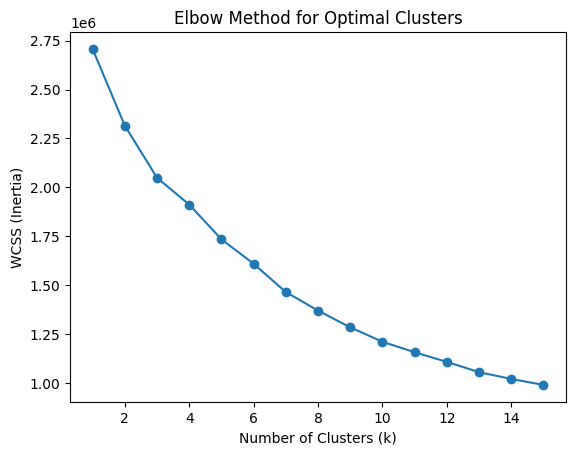

In [11]:
find_optimal_clusters_elbow(X_scaled)

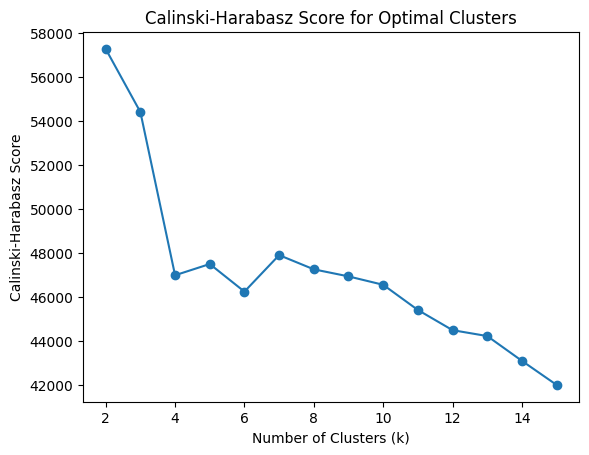

In [12]:
def find_optimal_clusters_calinski_harabasz(X, max_clusters=15):
    ch_scores = []
    for k in range(2, max_clusters + 1):  # CH score is not defined for k=1
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        ch_scores.append(calinski_harabasz_score(X, labels))

    plt.plot(range(2, max_clusters + 1), ch_scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Score for Optimal Clusters')
    plt.show()

find_optimal_clusters_calinski_harabasz(X_scaled)

### looking at these graphs, elbow method gives k= 7 or 8 and while maximising CH score k = 7 . Hence final no. of clusters = 7


## Comparing scores for different algorithms

In [12]:
def compute_clustering_scores(X, labels):
    unique_labels = set(labels)
    if len(unique_labels) < 2:
        return np.nan, np.nan, np.nan
    return (
        silhouette_score(X, labels),
        calinski_harabasz_score(X, labels),
        davies_bouldin_score(X, labels)
    )

def clustering_analysis(X):
    clustering_algorithms = {
        "KMeans": KMeans(n_clusters=7, random_state=42, n_init=10),
        "BIRCH": Birch(n_clusters=7),
        "Gaussian Mixture": GaussianMixture(n_components=7, random_state=42),     
    }
    
    print(f"{'Method':<25}{'Silhouette Score':<20}{'Calinski-Harabasz Score':<25}{'Davies-Bouldin Score'}")
    print("=" * 80)
    
    for method, model in clustering_algorithms.items():
        labels = model.fit_predict(X)
        sil_score,ch_score, db_score = compute_clustering_scores(X, labels)
        print(f"{method:<25}{sil_score:<20.4f}{ch_score:<25.4f}{db_score:.4f}")

clustering_analysis(X_scaled)

Method                   Silhouette Score    Calinski-Harabasz Score  Davies-Bouldin Score
KMeans                   0.1995              47906.9184               1.2326
BIRCH                    0.6138              23369.3622               0.8626
Gaussian Mixture         -0.0590             14233.3566               3.1914


### BIRCH surpasses other algorithms

## K means

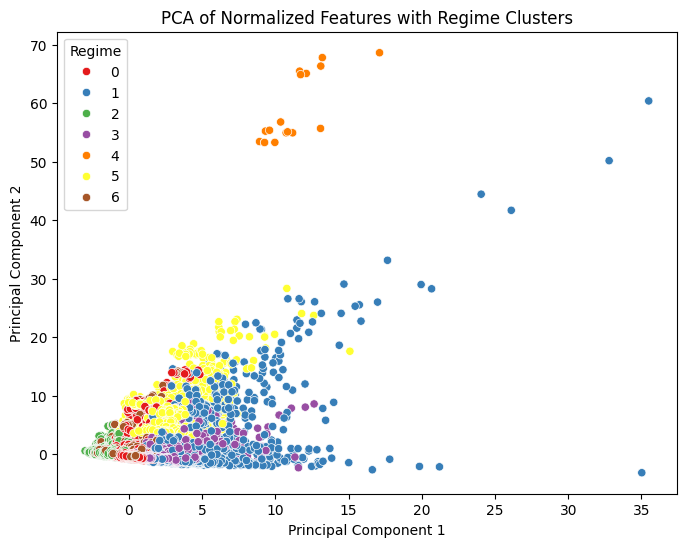

In [44]:
optimal_k = 7
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
clustering_df['regime_kmeans'] = kmeans_final.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=clustering_df['regime_kmeans'], palette='Set1')
plt.title('PCA of Normalized Features with Regime Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Regime')
plt.show()


### Gaussian Mixture Model (soft assignments/probabilities)

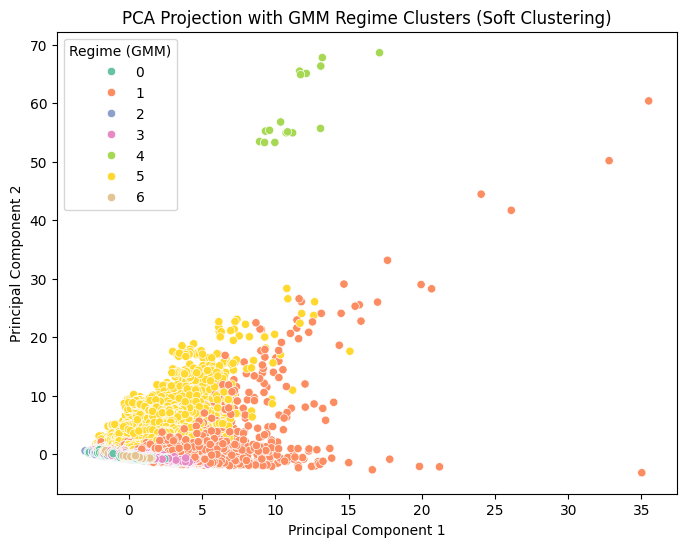

In [30]:
n_components = 7  
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_scaled)

# Hard clustering
clusters_gmm = gmm.predict(X_scaled)
# soft cluster membership probabilities 
cluster_probs = gmm.predict_proba(X_scaled)
clustering_df['regime_gmm'] = clusters_gmm

for i in range(n_components):
    clustering_df[f'regime_{i}_prob'] = cluster_probs[:, i]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],  
                hue=clustering_df['regime_gmm'], palette='Set2', legend='full')
plt.title('PCA Projection with GMM Regime Clusters (Soft Clustering)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Regime (GMM)')
plt.show()



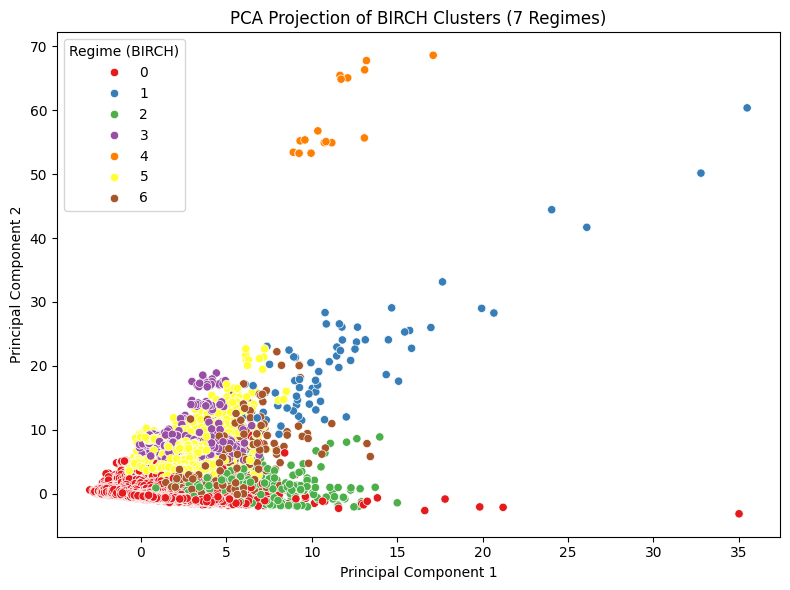

In [42]:
birch_model = Birch(n_clusters=7)
clusters_birch = birch_model.fit_predict(X_scaled)

clustering_df['regime'] = clusters_birch

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=clustering_df['regime'], palette='Set1', legend='full')
plt.title("PCA Projection of BIRCH Clusters (7 Regimes)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Regime (BIRCH)")
plt.tight_layout()
plt.show()




In [43]:
merged_df = merged_df.loc[clustering_df.index].copy()
merged_df['regime'] = clustering_df['regime']

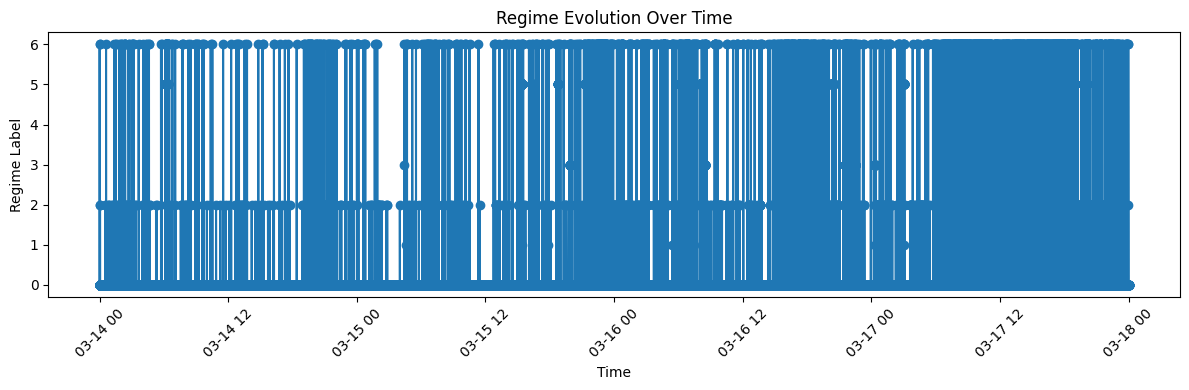

In [46]:
plt.figure(figsize=(12, 4))
plt.plot(merged_df['Time'], merged_df['regime'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Regime Label')
plt.title('Regime Evolution Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Regime labelling and Analysis

Summary of Regimes:
   regime  avg_volatility  avg_spread  avg_mid_return  avg_cum_bid_qty  \
0       0        0.000055    0.078821        0.000010        59.952544   
1       1        0.000201    0.096945        0.000177        54.377365   
2       2        0.000062    0.049001       -0.000003        56.534369   
3       3        0.000112    0.100366       -0.000051        54.963795   
4       4        0.000078    0.112941       -0.000024      1608.761765   
5       5        0.000074    0.088107       -0.000007      1151.969559   
6       6        0.000058    0.075357        0.000005        62.597047   

   avg_cum_ask_qty  avg_quantity   count                 regime_description  
0        70.314279      1.127895   95821                    Stable & Liquid  
1        75.824777     20.569291   12272                Volatile & Illiquid  
2        55.897729      1.704469  119681        Transitionary / Fluctuating  
3        54.820634      3.254344   55946  Positive Trending & Highly Liquid

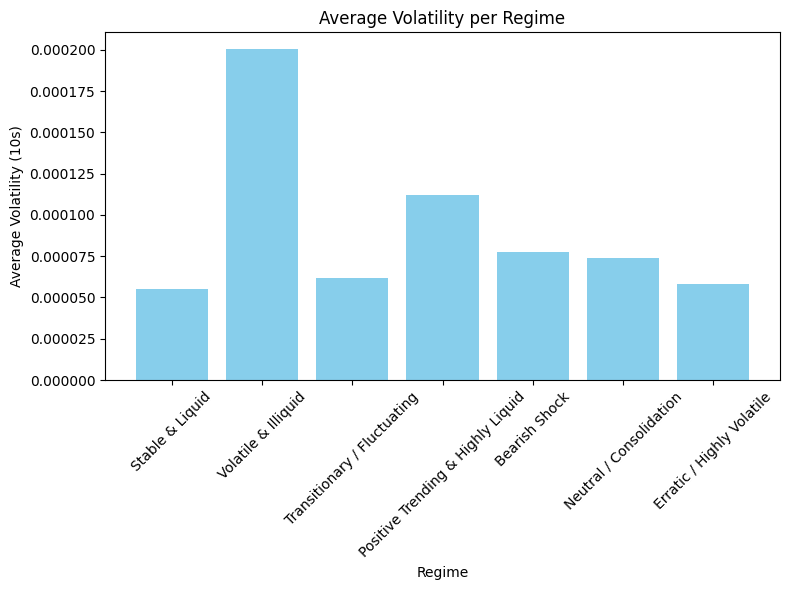

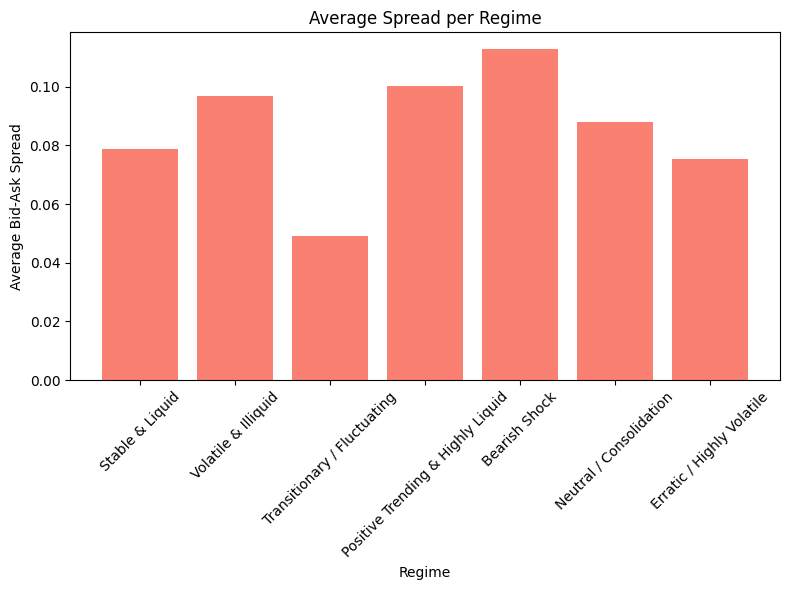

In [18]:
# summary statistics per regime.
regime_summary = merged_df.groupby('regime').agg(
    avg_volatility = ('volatility_10s', 'mean'),
    avg_spread     = ('bid_ask_spread', 'mean'),
    avg_mid_return = ('mid_return', 'mean'),
    avg_cum_bid_qty= ('cum_bid_qty', 'mean'),
    avg_cum_ask_qty= ('cum_ask_qty', 'mean'),
    avg_quantity   = ('Quantity', 'mean'),
    count          = ('Time', 'count')
).reset_index()

# names for each regime.
# These names are suggestions, I doesn't have any expertise in naming them, just named using GPT
regime_names = {
    0: "Stable & Liquid",
    1: "Volatile & Illiquid",
    2: "Transitionary / Fluctuating",
    3: "Positive Trending & Highly Liquid",
    4: "Bearish Shock",
    5: "Neutral / Consolidation",
    6: "Erratic / Highly Volatile"
}
regime_summary['regime_description'] = regime_summary['regime'].map(regime_names)

print("Summary of Regimes:")
print(regime_summary)


# average volatility by regime.
plt.figure(figsize=(8, 6))
plt.bar(regime_summary['regime_description'], regime_summary['avg_volatility'], color='skyblue')
plt.xlabel("Regime")
plt.ylabel("Average Volatility (10s)")
plt.title("Average Volatility per Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(8, 6))
plt.bar(regime_summary['regime_description'], regime_summary['avg_spread'], color='salmon')
plt.xlabel("Regime")
plt.ylabel("Average Bid-Ask Spread")
plt.title("Average Spread per Regime")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
#Similarly you can plot mid_return and etc.

## 5. Visualization

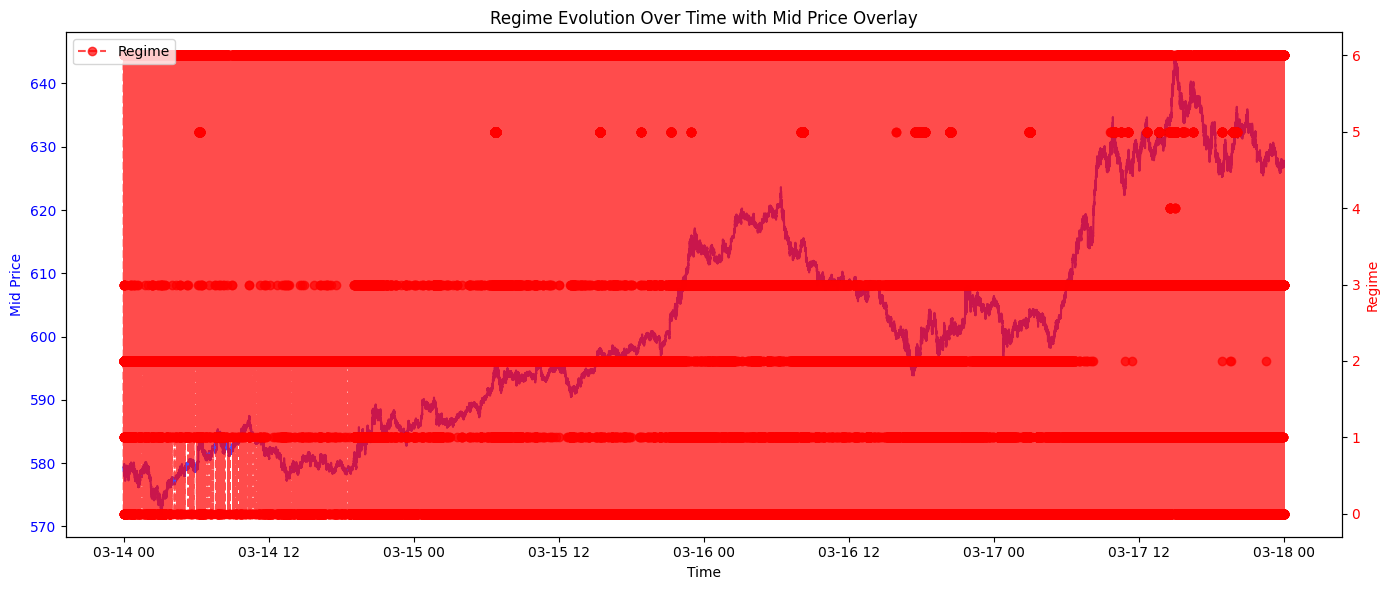

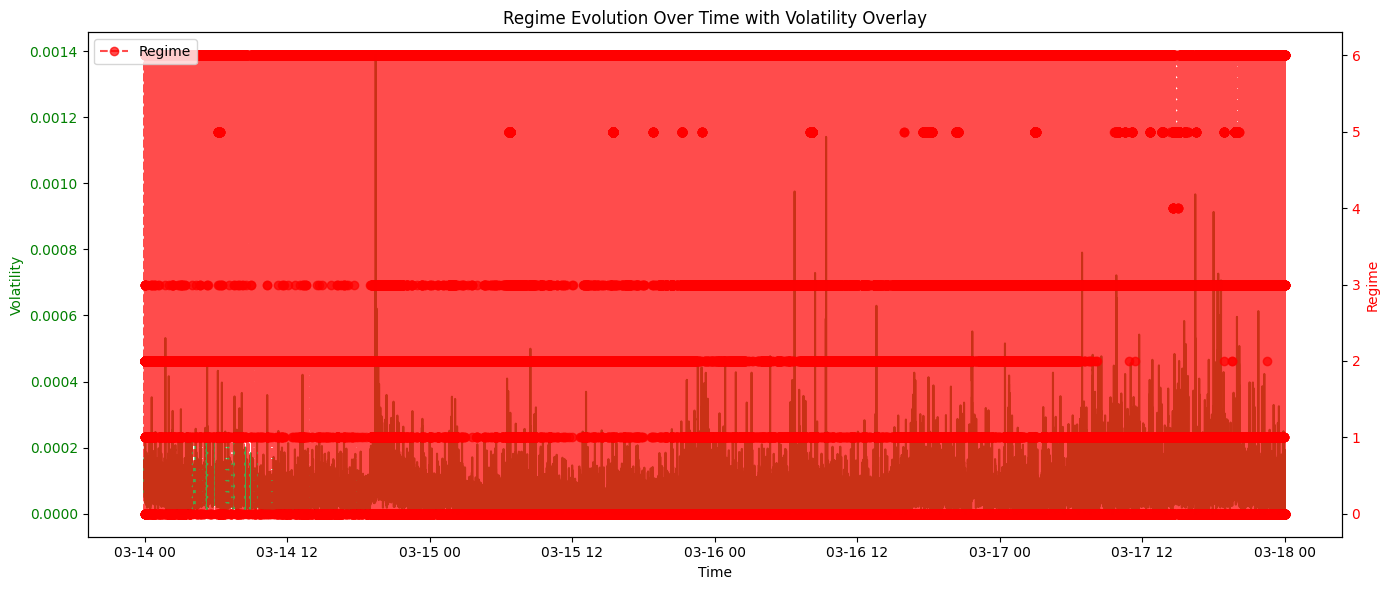

In [19]:
if 'mid_price' not in merged_df.columns and 'BidPriceL1' in merged_df.columns and 'AskPriceL1' in merged_df.columns:
    merged_df['mid_price'] = (merged_df['BidPriceL1'] + merged_df['AskPriceL1']) / 2

plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax1.plot(merged_df['Time'], merged_df['mid_price'], label='Mid Price', color='blue', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Mid Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(merged_df['Time'], merged_df['regime'], label='Regime', color='red', marker='o', linestyle='--', alpha=0.7)
ax2.set_ylabel('Regime', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Regime Evolution Over Time with Mid Price Overlay')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

#  overlay regime evolution with volatility.
if 'volatility_10s' in merged_df.columns:
    plt.figure(figsize=(14, 6))
    ax1 = plt.gca()
    ax1.plot(merged_df['Time'], merged_df['volatility_10s'], label='Volatility (10s)', color='green', alpha=0.7)
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Volatility', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx()
    ax2.plot(merged_df['Time'], merged_df['regime'], label='Regime', color='red', marker='o', linestyle='--', alpha=0.7)
    ax2.set_ylabel('Regime', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Regime Evolution Over Time with Volatility Overlay')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()



C:\Users\ashut\AppData\Local\Temp\ipykernel_59440\3658993829.py:15: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


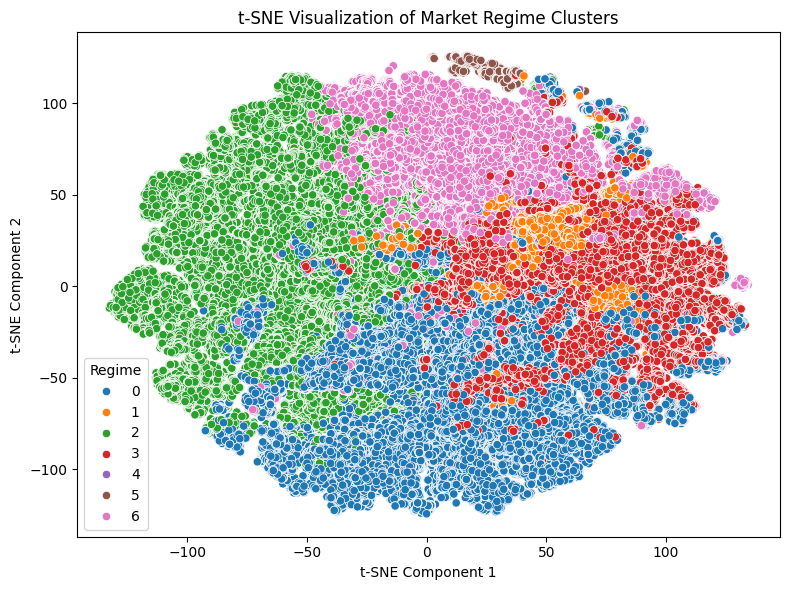

In [20]:
#  t-SNE Visualization 

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(15,15))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1],
                hue=clustering_df['regime'], palette='tab10', legend='full')
plt.title('t-SNE Visualization of Market Regime Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Regime')
plt.tight_layout()
plt.show()


## 6. Regime change analysis

In [14]:
def compute_transition_matrix(regimes):
    unique_regimes = sorted(regimes.unique())
    n = len(unique_regimes)
    matrix = np.zeros((n, n), dtype=int)
    for (r1, r2) in zip(regimes[:-1], regimes[1:]):
        matrix[r1, r2] += 1
    return pd.DataFrame(matrix,
                        index=[f"From {i}" for i in unique_regimes],
                        columns=[f"To {i}" for i in unique_regimes])

transition_matrix = compute_transition_matrix(merged_df['regime'].reset_index(drop=True))
print("Transition Matrix between Regimes:")
print(transition_matrix)

Transition Matrix between Regimes:
         To 0  To 1   To 2   To 3  To 4  To 5   To 6
From 0  63726  1258  10430   7689     0    39  12679
From 1    856  4143    929   5553     1    50    740
From 2  10275   977  98769    846     0    14   8800
From 3   8200  4976    836  38193     0    68   3673
From 4      0     0      0      0    14     3      0
From 5     41    73     14     42     2  1921     20
From 6  12723   845   8702   3623     0    18  26744


In [15]:
transition_probabilities = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

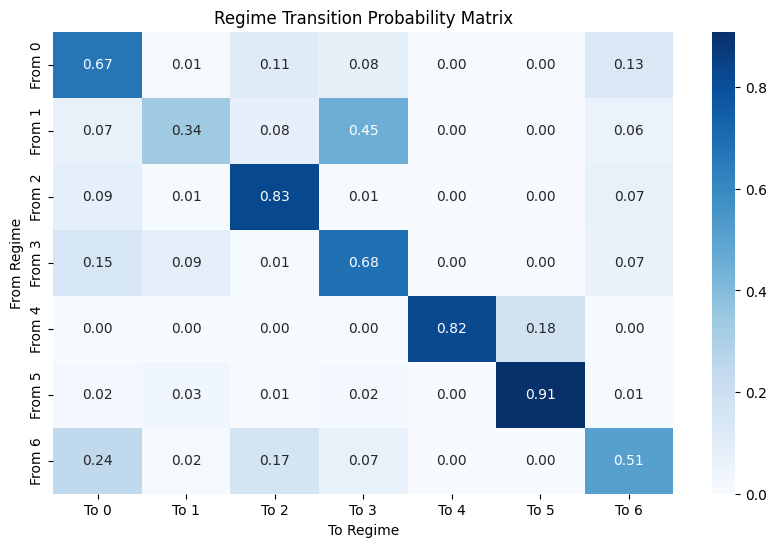

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(transition_probabilities, annot=True, cmap='Blues', fmt=".2f")
plt.title("Regime Transition Probability Matrix")
plt.xlabel("To Regime")
plt.ylabel("From Regime")
plt.show()